In [143]:
# Import section libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from datetime import datetime, timedelta
from matplotlib.pyplot import rcParams
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf, adfuller, pacf

In [17]:
# Some settings

# PATH

PATH = '../../Raw Data sets/Sauti Africa Market Monitoring/eac-ratin.csv'

# Size of plottings

rcParams['figure.figsize'] = 20,6

In [18]:
prices = pd.read_csv(PATH)

In [19]:
prices.head()

,Market,Product,Country,Date,Retail (MT),Wholesale (MT),Currency
0,Bujumbura,Maize,Burundi,10/4/2011,0,548798,BIF
1,Bujumbura,Maize,Burundi,10/5/2011,0,549000,BIF
2,Bujumbura,Maize,Burundi,10/6/2011,0,498970,BIF
3,Bujumbura,Maize,Burundi,10/7/2011,0,549299,BIF
4,Bujumbura,Maize,Burundi,10/10/2011,0,549872,BIF


In [20]:
# There are duplicated dates!

lira = prices[prices['Market'] == 'Lira']
print(lira.shape)
lira[['Date']].nunique()

(2397, 7)


Date    1949
dtype: int64

In [21]:
# drop duplicated rows in terms of Dates.
lira = lira.drop(labels=lira[lira.duplicated(['Date'], keep='first')].index, axis=0)

In [22]:
lira['Date'] = pd.to_datetime(lira['Date'], infer_datetime_format=True)
lira = lira.set_index('Date')
lira = lira[['Wholesale (MT)']].astype(float) / 1000
lira = lira[lira.index >= '2010-12-31']
lira.head()

,Wholesale (MT)
Date,
2011-03-04,499.489
2011-03-07,499.655
2011-03-10,500.561
2011-03-15,494.353
2011-03-21,498.928


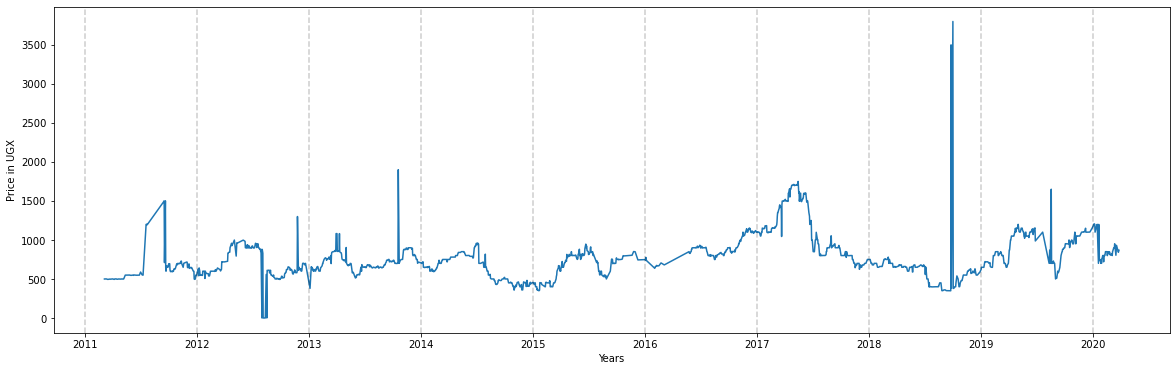

In [23]:

timeseries_prices = plt.plot(lira['Wholesale (MT)'], label = 'Maize Price')
# upper_band = plt.plot(month_rolmean + 2 * month_rolstd, color='red', label='Crisis band')
# lower_band = plt.plot(month_rolmean + 1.5 * month_rolstd, color='orange', label='Alert mean')
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.show()



In [24]:
# I'm building a dataframe with all the possible dates between start='2/27/2011', end='3/28/2020'.

dummy = pd.DataFrame()
dummy['dates'] = pd.date_range(start='2/28/2011', end='3/29/2020')
dummy = dummy.set_index('dates')
lira = dummy.merge(lira, how='outer', left_index=True, right_index=True)
print(dummy.shape)
lira.shape

(3318, 0)


(3318, 1)

In [25]:
# Searching to the outliers.

z = np.abs(stats.zscore(lira['Wholesale (MT)'], nan_policy='omit'))


dates_to_drop = [lira.iloc[i:i+1,:].index[0] for i in list(np.where(z>4)[0])]
dates_to_drop = dates_to_drop + list(lira[lira['Wholesale (MT)'] <= 0].index)
lira = lira.drop(dates_to_drop, axis=0)
lira

C:\Users\jcm\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


,Wholesale (MT)
2011-02-28,NaN
2011-03-01,NaN
2011-03-02,NaN
2011-03-03,NaN
2011-03-04,499.489
...,...
2020-03-25,842.071
2020-03-26,NaN
2020-03-27,868.066
2020-03-28,NaN


In [26]:
lira['mean_price_7days'] = lira['Wholesale (MT)'].rolling(window=7,min_periods=1).mean()
# lira['std_price_7days'] = lira['Wholesale (MT)'].rolling(window=7,min_periods=2).std()

lira['number_of_day'] = [i%7 +1 for i in range(len(lira))]

# lira['difference'] = np.where(lira['Wholesale (MT)'] >= (lira['mean_price_7days'] + 2*lira['std_price_7days']), 'Yes','No' )
print(lira.shape)
lira.head(25)

(3308, 3)


,Wholesale (MT),mean_price_7days,number_of_day
2011-02-28,NaN,NaN,1
2011-03-01,NaN,NaN,2
2011-03-02,NaN,NaN,3
2011-03-03,NaN,NaN,4
2011-03-04,499.489,499.489000,5
2011-03-05,NaN,499.489000,6
2011-03-06,NaN,499.489000,7
2011-03-07,499.655,499.572000,1
2011-03-08,NaN,499.572000,2
2011-03-09,NaN,499.572000,3


In [27]:
lira.tail(25)

,Wholesale (MT),mean_price_7days,number_of_day
2020-03-05,800.240,808.239000,1
2020-03-06,847.486,822.575667,2
2020-03-07,NaN,822.575667,3
2020-03-08,NaN,822.575667,4
2020-03-09,NaN,822.575667,5
2020-03-10,899.079,848.935000,6
2020-03-11,NaN,848.935000,7
2020-03-12,900.343,882.302667,1
2020-03-13,950.518,916.646667,2
2020-03-14,NaN,916.646667,3


In [28]:
# looking for weeks with no values at all.

lira[lira['number_of_day'] == 7]['mean_price_7days'][lira[lira['number_of_day'] == 7]['mean_price_7days'].isnull()]

2011-05-22   NaN
2011-07-17   NaN
2011-07-31   NaN
2011-08-07   NaN
2011-08-14   NaN
2011-08-21   NaN
2011-08-28   NaN
2011-09-04   NaN
2011-09-11   NaN
2011-11-27   NaN
2012-05-20   NaN
2012-05-27   NaN
2012-12-30   NaN
2015-09-07   NaN
2015-11-02   NaN
2015-11-09   NaN
2015-11-16   NaN
2015-12-07   NaN
2015-12-21   NaN
2015-12-28   NaN
2016-01-18   NaN
2016-01-25   NaN
2016-02-01   NaN
2016-03-14   NaN
2016-03-21   NaN
2016-03-28   NaN
2016-04-04   NaN
2016-04-11   NaN
2016-04-18   NaN
2016-04-25   NaN
2016-05-02   NaN
2016-05-09   NaN
2016-05-16   NaN
2016-05-23   NaN
2019-07-10   NaN
2019-07-17   NaN
2019-07-31   NaN
Name: mean_price_7days, dtype: float64

In [29]:
# Filling those gaps

weekly_lira = pd.DataFrame(lira[lira['number_of_day'] == 7]['mean_price_7days'].interpolate())
weekly_lira = weekly_lira.set_index(pd.date_range(start='2011-03-06', periods=len(weekly_lira), freq='w'))
weekly_lira

,mean_price_7days
2011-03-06,499.489000
2011-03-13,500.108000
2011-03-20,494.353000
2011-03-27,498.218750
2011-04-03,500.078500
...,...
2020-02-16,841.388250
2020-02-23,812.238500
2020-03-01,848.935000
2020-03-08,884.899667


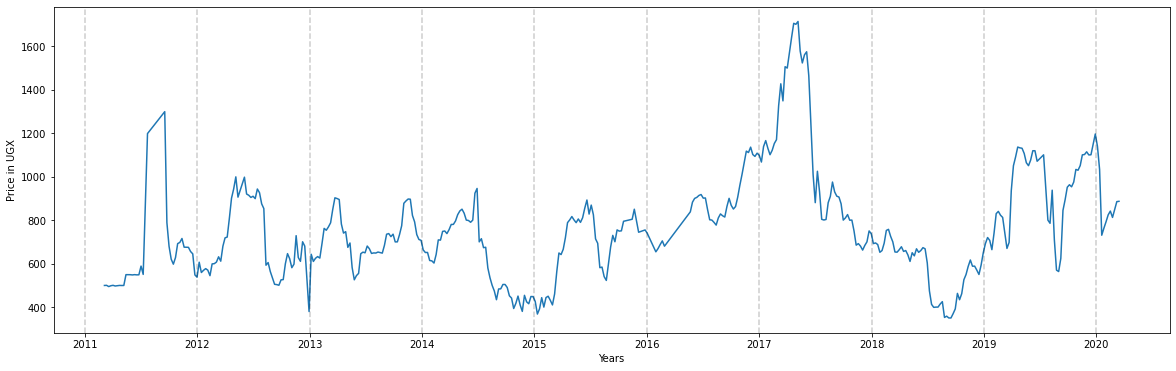

In [30]:
timeseries_prices = plt.plot(weekly_lira, label = 'Maize Price')
# upper_band = plt.plot(month_rolmean + 2 * month_rolstd, color='red', label='Crisis band')
# lower_band = plt.plot(month_rolmean + 1.5 * month_rolstd, color='orange', label='Alert mean')
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.show()


In [31]:
# Augmented Dickey-Fuller test


'''
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.
The intuition behind a unit root is that it determines how strongly a time series is defined by a trend.
The more negative the statistic is, the more likely to reject the null hypothesis, this mean, 
    the data has a unit root and is non-stationary. It has some time dependency.
'''


result_adft = adfuller(weekly_lira)
print(f'ADF Statistic: {round(result_adft[0],4)}')
print(f'p-value: {round(result_adft[1],4)}')
print('Critical Values:')
for key, value in result_adft[4].items():
    print(f'{key}: {round(value,4)}')

ADF Statistic: -3.8136
p-value: 0.0028
Critical Values:
1%: -3.4443
5%: -2.8677
10%: -2.5701


The statistic is lower than all the critical values, so I reject the Null Hypothesis with a confidence of 99%, meaning that the Time Series is stationary.

## ACF 

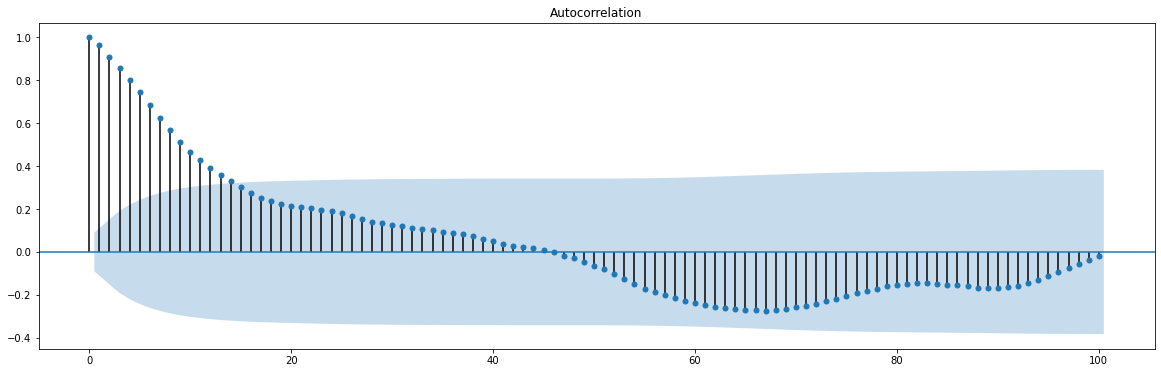

In [32]:
acf_plot = plot_acf(weekly_lira, lags=100)

## PACF

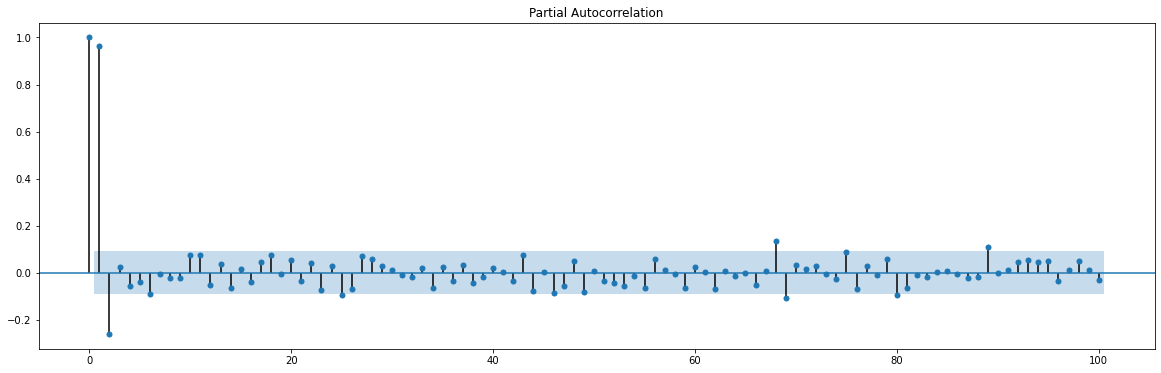

In [33]:
pacf_plot = plot_pacf(weekly_lira, lags=100)

In [35]:
# First approach to splitting the data into train and testing set.


train_end = datetime(2020,2,23)
test_end = datetime(2020,3,22)

train_data = weekly_lira[:train_end]
test_data = weekly_lira[train_end + timedelta(weeks=1):test_end]


In [36]:
res = sm.tsa.arma_order_select_ic(train_data, ic='aic', trend='c')
res.aic_min_order

C:\Users\jcm\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 2)

## SARIMA(4,0,2,4)

In [140]:
# Create the model

premodel = sm.tsa.SARIMAX(train_data, seasonal_order=(4,0,2,4))
model = premodel.fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                       mean_price_7days   No. Observations:                  469
Model:             SARIMAX(1, 0, 0)x(4, 0, [1, 2], 4)   Log Likelihood               -2626.732
Date:                                Sat, 09 May 2020   AIC                           5269.465
Time:                                        23:06:29   BIC                           5302.670
Sample:                                    03-06-2011   HQIC                          5282.530
                                         - 02-23-2020                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9968      0.006    162.289      0.000       0.985       1.009
ar.S.L4        0.0861      0.362      0.238      0.812      -0.623       0.795
ar.S.L8        0.9067      0.393      2.305      0.021       0.136       1.678
ar.S.L12      -0.0022      0.055     -0.041      0.967      -0.109       0.105
ar.S.L16       0.0056      0.062      0.091      0.928      -0.116       0.127
ma.S.L4       -0.0728      0.417     -0.174      0.861      -0.891       0.745
ma.S.L8       -0.9258      0.437     -2.120      0.034      -1.781      -0.070
sigma2      4242.1134    416.337     10.189      0.000    3426.107    5058.119
===================================================================================
Ljung-Box (Q):                       71.78   Jarque-Bera (JB):              3316.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.98
Prob(H) (two-sided):                  0.45   Kurtosis:                        15.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [126]:
fcast = model.get_forecast(steps=10)
fcast.summary_frame()

mean_price_7days,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-03-01,797.914824,62.749561,674.927944,920.901704
2020-03-08,802.360258,100.071790,606.223153,998.497363
2020-03-15,791.836095,128.273658,540.424345,1043.247844
2020-03-22,793.370760,152.244771,494.976493,1091.765027
2020-03-29,792.357666,172.532498,454.200185,1130.515148
2020-04-05,783.892067,190.638453,410.247566,1157.536569
2020-04-12,789.792816,207.313195,383.466421,1196.119212
2020-04-19,780.464277,222.272412,344.818354,1216.110199
2020-04-26,780.987177,236.569854,317.318783,1244.655571
2020-05-03,781.034257,249.765457,291.502958,1270.565557


In [141]:
alert_bands = fcast.summary_frame()

alert_bands['normal'] = alert_bands['mean'] + 0.25 * alert_bands['mean_se']

alert_bands['stress'] = alert_bands['mean'] + alert_bands['mean_se']

alert_bands['crisis'] = alert_bands['mean'] + 2 * alert_bands['mean_se']

alert_bands

mean_price_7days,mean,mean_se,mean_ci_lower,mean_ci_upper,normal,stress,crisis
2020-03-01,797.914824,62.749561,674.927944,920.901704,813.602214,860.664385,923.413947
2020-03-08,802.360258,100.071790,606.223153,998.497363,827.378206,902.432048,1002.503839
2020-03-15,791.836095,128.273658,540.424345,1043.247844,823.904509,920.109753,1048.383410
2020-03-22,793.370760,152.244771,494.976493,1091.765027,831.431953,945.615530,1097.860301
2020-03-29,792.357666,172.532498,454.200185,1130.515148,835.490790,964.890164,1137.422661
2020-04-05,783.892067,190.638453,410.247566,1157.536569,831.551680,974.530520,1165.168973
2020-04-12,789.792816,207.313195,383.466421,1196.119212,841.621115,997.106011,1204.419206
2020-04-19,780.464277,222.272412,344.818354,1216.110199,836.032380,1002.736689,1225.009101
2020-04-26,780.987177,236.569854,317.318783,1244.655571,840.129640,1017.557031,1254.126885
2020-05-03,781.034257,249.765457,291.502958,1270.565557,843.475621,1030.799714,1280.565171


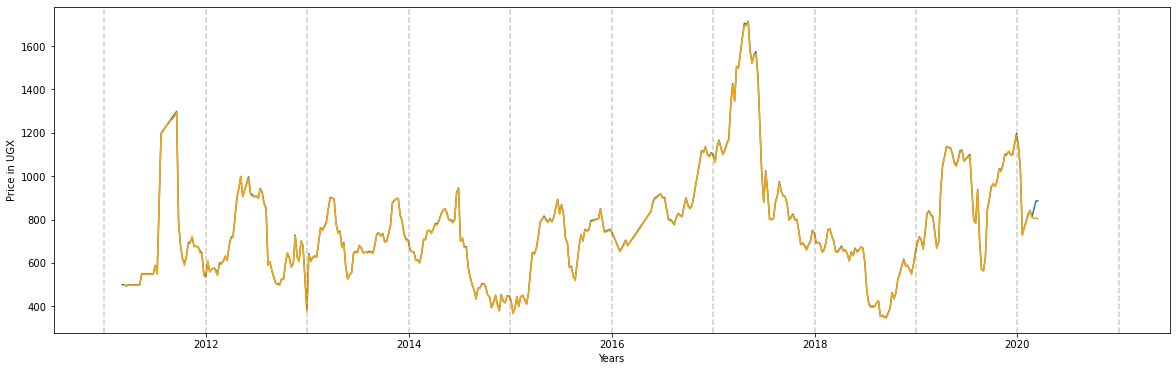

In [136]:
timeseries_prices = plt.plot(weekly_lira, label = 'Maize Price')
plt.plot(model.predict(1,472).shift(-1), label='predictions', color='orange')

for year in range(2011,2022):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.show()



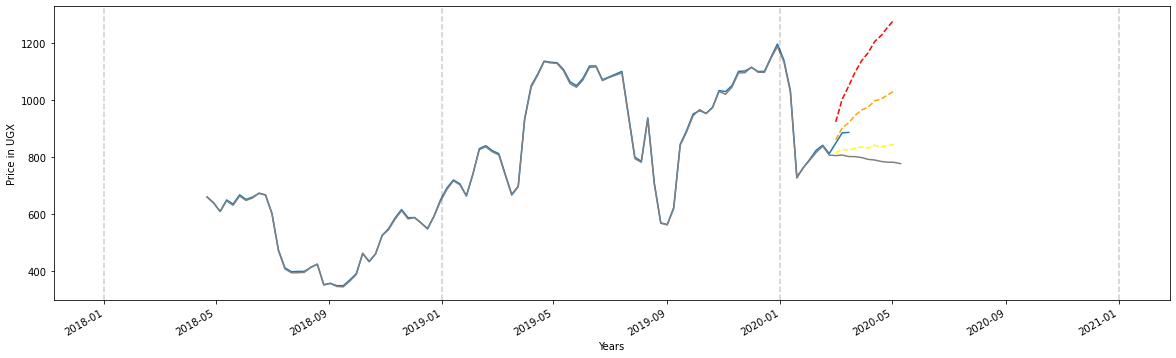

In [142]:
timeseries_prices = plt.plot(weekly_lira[-100:], label = 'Maize Price')
plt.plot(model.predict(str(weekly_lira[-100:].index[0])[:10],480).shift(-1), label='predictions', color='gray')

alert_bands['normal'].plot(color='yellow', style='--')
alert_bands['stress'].plot(color='orange', style='--')
alert_bands['crisis'].plot(color='red', style='--')

for year in range(2018,2022):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.savefig('sarima_maize_alert_crisis_bands_test.png')
plt.show()

(472, 1)

## ARMA(4,2)

In [221]:
# Create the model

premodel = ARMA(train_data, order=(4,2))
model = premodel.fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       mean_price_7days   No. Observations:                  469
Model:                     ARMA(4, 2)   Log Likelihood               -2600.725
Method:                       css-mle   S.D. of innovations             61.742
Date:                Sun, 10 May 2020   AIC                           5217.449
Time:                        00:01:52   BIC                           5250.654
Sample:                    03-06-2011   HQIC                          5230.514
                         - 02-23-2020                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    763.6613     56.833     13.437      0.000     652.271     875.051
ar.L1.mean_price_7days     2.7003      0.066     40.847      0.000       2.571       2.830
ar.L2.mean_price_7days    -2.9790      0.142    -20.954      0.000      -3.258      -2.700
ar.L3.mean_price_7days     1.5345      0.122     12.576      0.000       1.295       1.774
ar.L4.mean_price_7days    -0.2760      0.046     -5.949      0.000      -0.367      -0.185
ma.L1.mean_price_7days    -1.5075      0.054    -28.082      0.000      -1.613      -1.402
ma.L2.mean_price_7days     0.9226      0.047     19.579      0.000       0.830       1.015
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8564           -0.6902j            1.0999           -0.1080
AR.2            0.8564           +0.6902j            1.0999            0.1080
AR.3            1.0839           -0.0000j            1.0839           -0.0000
AR.4            2.7628           -0.0000j            2.7628           -0.0000
MA.1            0.8169           -0.6453j            1.0411           -0.1064
MA.2            0.8169           +0.6453j            1.0411            0.1064
-----------------------------------------------------------------------------
"""

In [222]:
steps = 12
predictions = pd.DataFrame(model.forecast(steps=steps)).copy().T
predictions = predictions.rename({0:'forecast',1:'stderr',2:'conf_int'}, axis=1)
predictions['dates'] = [weekly_lira.index[-1] + timedelta(weeks=i) for i in range(steps)]
predictions = predictions.set_index('dates')

predictions['normal'] = predictions['forecast'] + 0.25 * predictions['stderr']

predictions['stress'] = predictions['forecast'] + predictions['stderr']

predictions['crisis'] = predictions['forecast'] + 2 * predictions['stderr']


predictions



,forecast,stderr,conf_int,normal,stress,crisis
dates,,,,,,
2020-03-15,797.852,61.7423,"[676.8395160791567, 918.864994561399]",813.288,859.595,921.337
2020-03-22,802.315,96.1021,"[613.9580505072865, 990.671221122753]",826.34,898.417,994.519
2020-03-29,819.267,120.017,"[584.038717593562, 1054.4957709139137]",849.271,939.284,1059.3
2020-04-05,837.72,138.678,"[565.916032197706, 1109.524003222878]",872.39,976.398,1115.08
2020-04-12,847.863,155.08,"[543.9114982857018, 1151.814828373056]",886.633,1002.94,1158.02
2020-04-19,845.063,170.328,"[511.22557845439104, 1178.9003608443622]",887.645,1015.39,1185.72
2020-04-26,830.922,184.226,"[469.8449315750155, 1191.9983743171497]",876.978,1015.15,1199.37
2020-05-03,811.55,196.046,"[427.30732996811037, 1195.792344812597]",860.561,1007.6,1203.64
2020-05-10,794.272,205.27,"[391.9492109492861, 1196.594595481481]",845.59,999.542,1204.81


In [223]:
past_predictions = model.predict(1,len(weekly_lira))

In [224]:
weekly_lira.loc[predictions.index[0]]
# predictions.index[0]

mean_price_7days    886.347
Name: 2020-03-15 00:00:00, dtype: float64

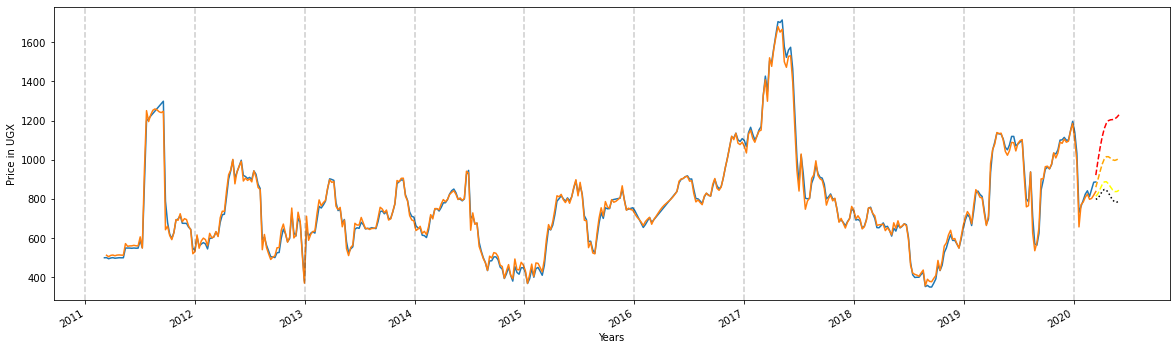

In [225]:
timeseries_prices = plt.plot(weekly_lira, label = 'Maize Price')
plt.plot(past_predictions.shift(-1), label='past predictions')

predictions['forecast'].plot(color='black', style=':')
predictions['normal'].plot(color='yellow', style='--')
predictions['stress'].plot(color='orange', style='--')
predictions['crisis'].plot(color='red', style='--')


for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.show()


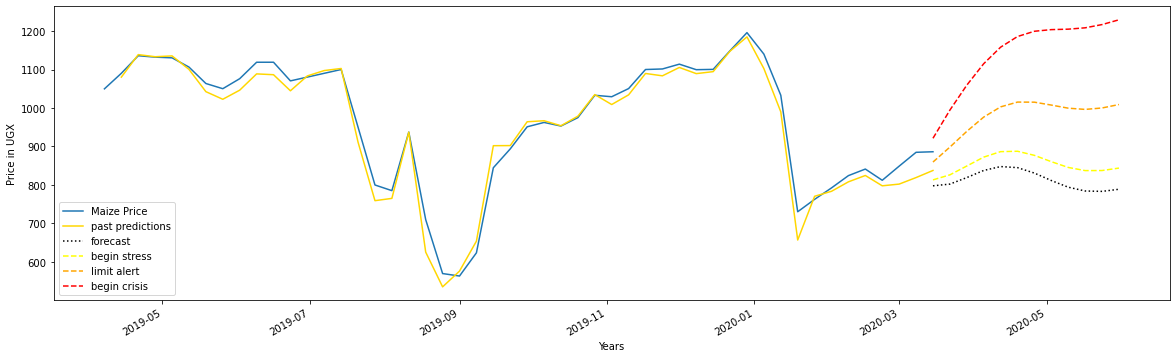

In [244]:

lag = 50

timeseries_prices = plt.plot(weekly_lira[-lag:], label = 'Maize Price')
plt.plot(past_predictions[-lag:].shift(-1), label='past predictions', color='gold')

predictions['forecast'][-lag:].plot(color='black', style=':')
predictions['normal'][-lag:].plot(color='yellow', style='--', label='begin stress')
predictions['stress'][-lag:].plot(color='orange', style='--', label='limit alert')
predictions['crisis'][-lag:].plot(color='red', style='--', label='begin crisis')


# for year in range(int(str(weekly_lira[-lag:].index[0])[:4]),2021):
#     plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.legend(loc='best')
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.savefig('arma_maize_alert_crisis_bands_test.png')
plt.show()

In [227]:
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_forecast_conf_int',
 '_forecast_error',
 '_get_robustcov_results',
 '_ic_df_model',
 '_use_t',
 'aic',
 'arfreq',
 'arparams',
 'arroots',
 'bic',
 'bse',
 'conf_int',
 'cov_params',
 'cov_params_default',
 'data',
 'df_model',
 'df_resid',
 'f_test',
 'fittedvalues',
 'forecast',
 'hqic',
 'initialize',
 'k_ar',
 'k_constant',
 'k_exog',
 'k_ma',
 'k_trend',
 'llf',
 'load',
 'mafreq',
 'maparams',
 'maroots',
 'mle_retvals',
 'mle_settings',
 'model',
 'n_totobs',
 'nobs',
 'normalized_cov_params',
 'params',
 'plot_predict',
 'predict',
 'pvalues',
 'remove_data',
 'resid',
 'save',
 'scale'

# Draft Section

In [ ]:
# Draft Libraries import 
from statsmodels.tsa.stattools import arma_order_select_ic

In [ ]:
weekly_lira

In [ ]:
weekly_lira.diff(2)

In [ ]:
decomposition = seasonal_decompose(weekly_lira)
dir(decomposition)
# decomposition.plot()
decomposition.weights

In [ ]:
# timeseries_prices = plt.plot(weekly_lira.ewm(halflife=1,min_periods=0,adjust=True).mean(), label = 'Maize Price')
# plt.plot(weekly_lira, label = 'Maize Price')
plt.plot(decomposition.seasonal, label = 'Maize Price')

# upper_band = plt.plot(month_rolmean + 2 * month_rolstd, color='red', label='Crisis band')
# lower_band = plt.plot(month_rolmean + 1.5 * month_rolstd, color='orange', label='Alert mean')
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.show()


In [ ]:
import statsmodels.api as sm
res = arma_order_select_ic(weekly_lira, max_ar=5, max_ma=3, ic='aic', trend='c')
print(res.aic_min_order)